In [12]:
import genjax

# ggp = genjax.tinygp()
import genjax._src.extras.tinygp as ggp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import tinygp.kernels as kernels
from genjax import trace

sns.set_theme(style="white")

# Pretty printing.
console = genjax.console(width=80)

# Reproducibility.
key = jax.random.PRNGKey(314159)

Gaussian process models are a well-explored nonparametric model class describing distributions over spaces of functions. They also support sampling, logpdf evaluation, as well as exact conditioning. In GenJAX, we support usage of Gaussian process models using an auxiliary library [`tinygp`](https://github.com/dfm/tinygp) which provides a lightweight implementation of the interfaces above for many common Gaussian process kernels.

In [13]:
ggp.GaussianProcess

genjax._src.extras.tinygp.tinygp.GaussianProcess

To construct a Gaussian process model which implements the generative function interface, it suffices to provide the constructor `gpp.GaussianProcess` with a `tinygp` kernel:

In [14]:
kernel_scaled = 4.5 * kernels.ExpSquared(scale=1.5)
model = ggp.GaussianProcess(kernel_scaled)
model

GaussianProcess(kernel=Product(kernel1=Constant(value=4.5), kernel2=ExpSquared(scale=1.5, distance=L2Distance())))

This model is a generative function - meaning it supports all the generative function interfaces.

In [15]:
isinstance(model, genjax.GenerativeFunction)

True

To call `simulate`, we must provide a grid for evaluation:

In [16]:
grid = jnp.arange(0.0, 50.0, 0.5)
grid

Array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5], dtype=float32)

We can visualize samples from our `genjax.GaussianProcess` - and of course, we can `jax.jit` our interfaces, as usual.

TypeError: 'ChoiceValue' object is not subscriptable

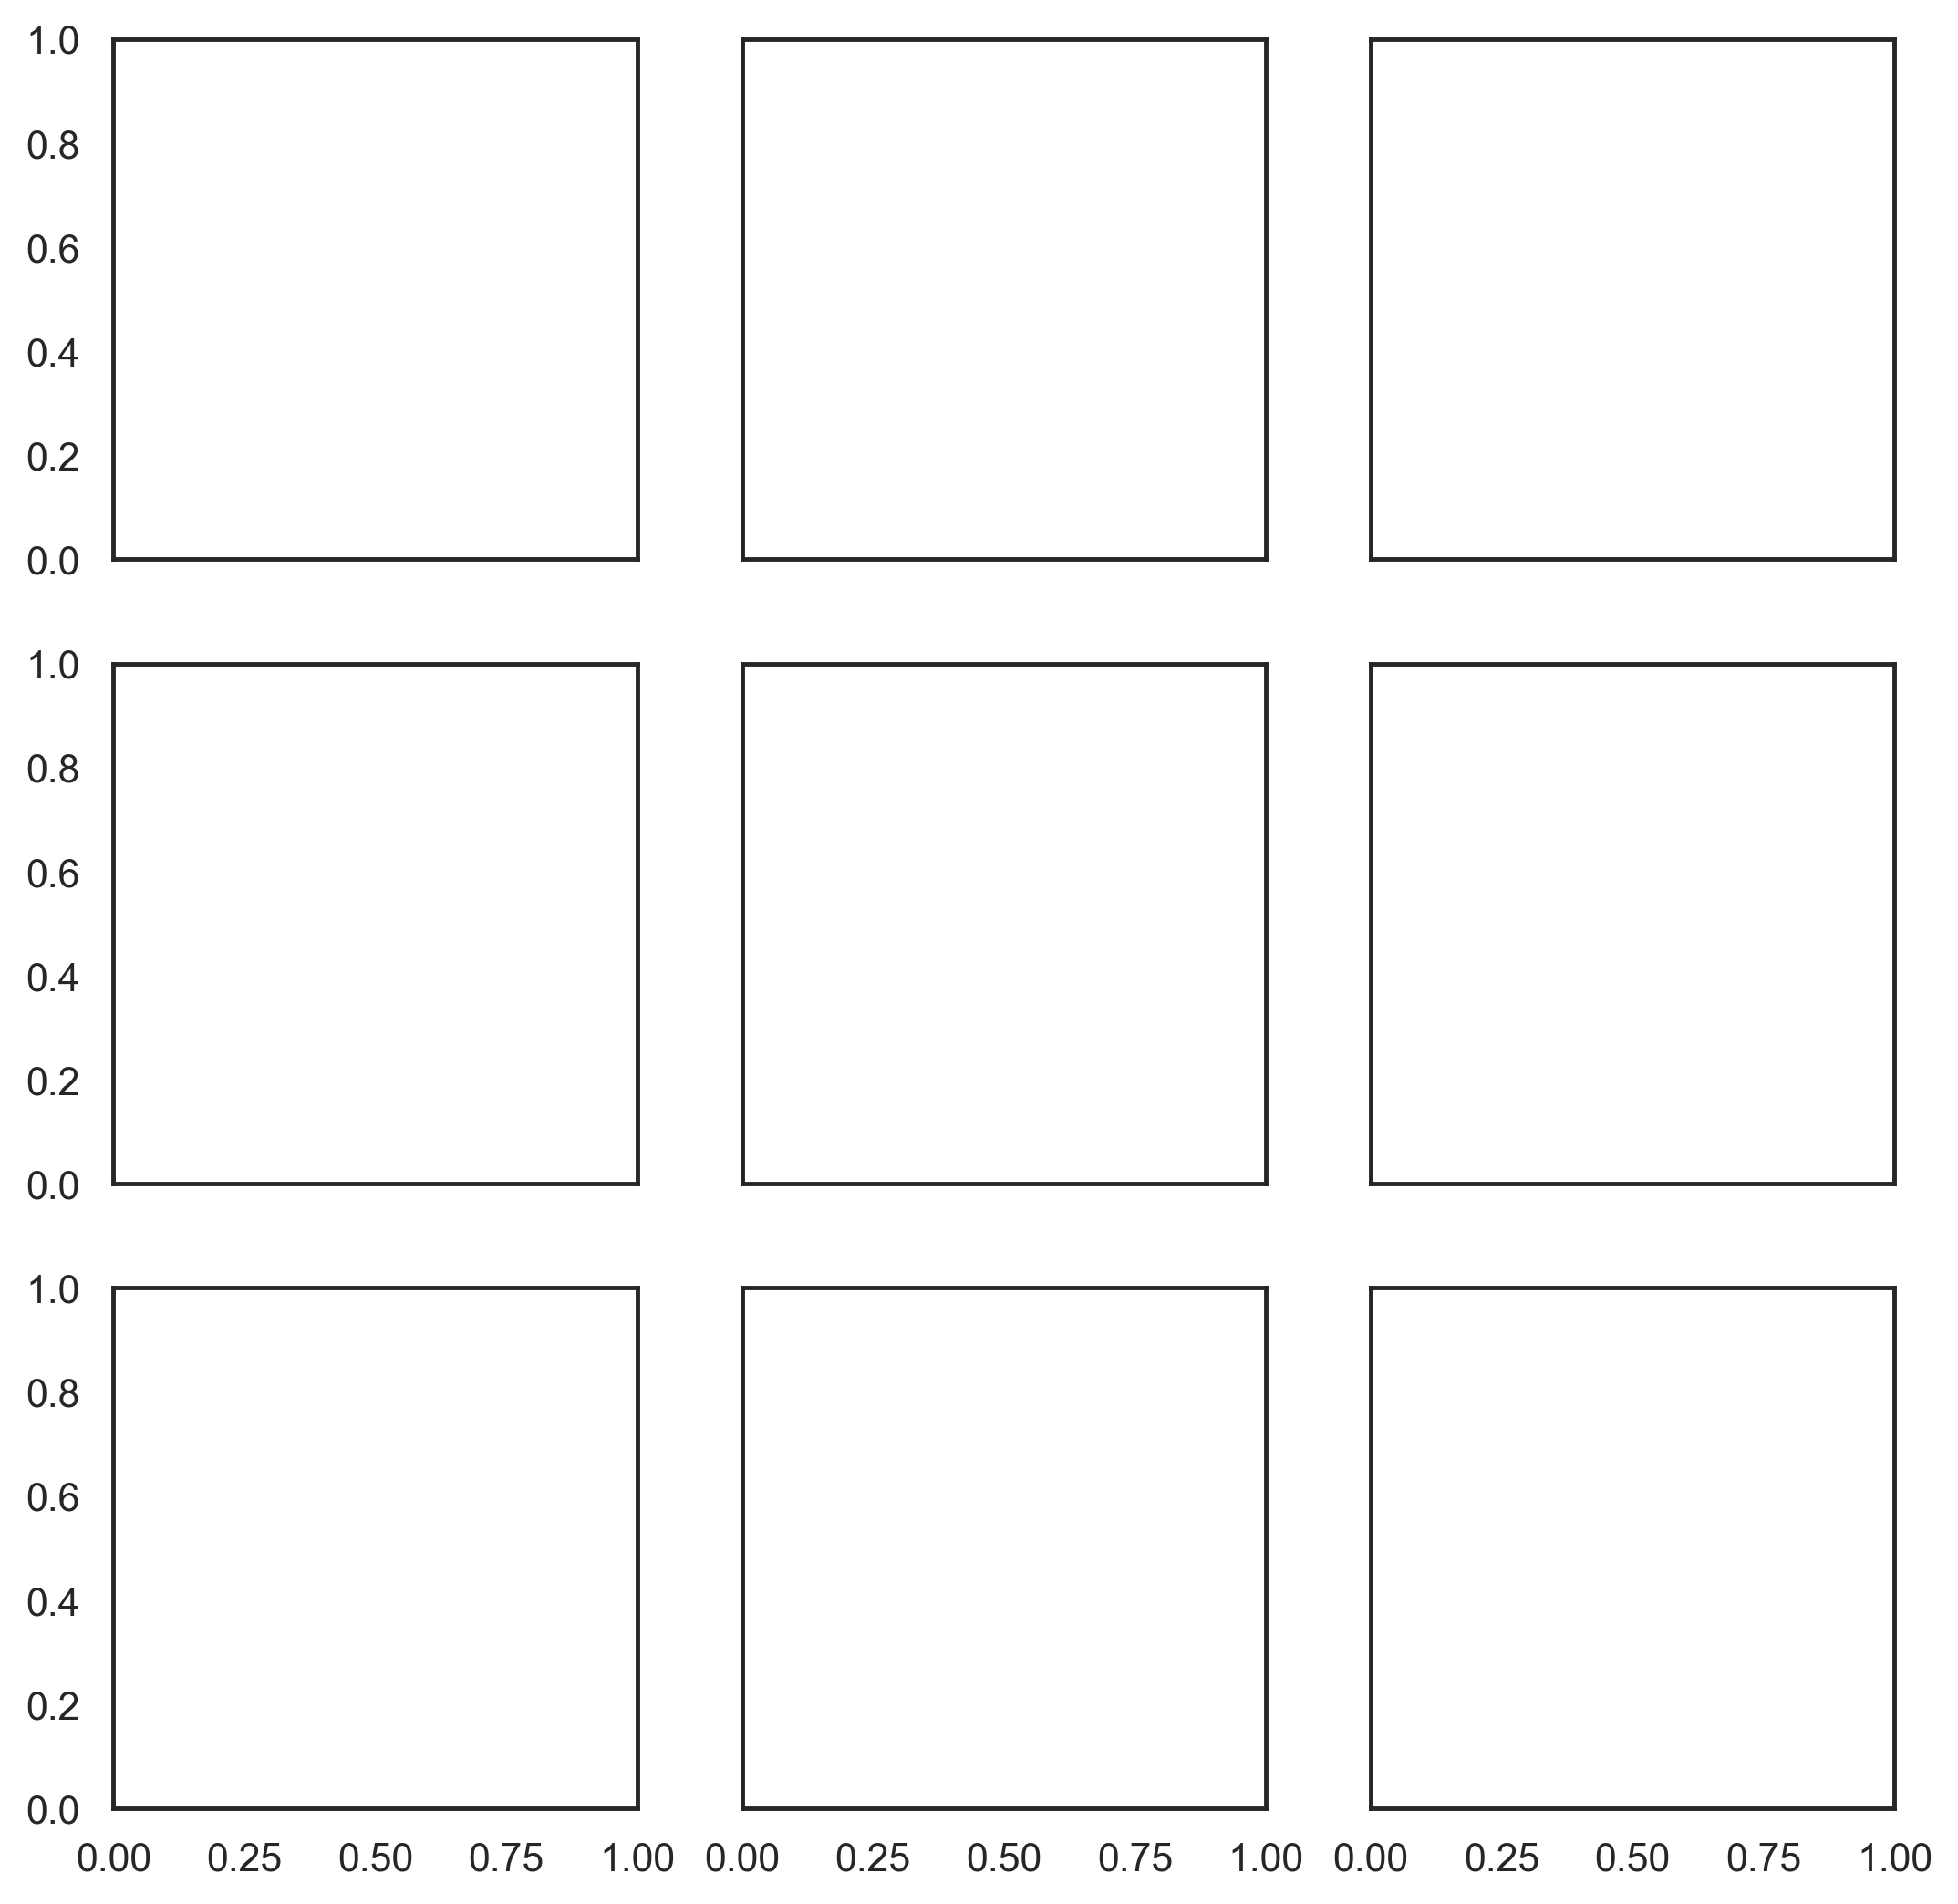

In [17]:
def viz(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)


f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True, dpi=280)
jitted = jax.jit(model.simulate)
for ax in axes.flatten():
    key, tr = jitted(key, (grid,))
    x = grid
    y = tr.get_retval()
    viz(ax, x, y, marker=".")

plt.show()

## Structured modeling and inference with GenJAX

Let's create some data, and then consider constructing a model and performing inference. Below, we'll consider a noisy sinusoidal data generating process.

In [18]:
key, sub_key = jax.random.split(key)
n = 50


def f(x):
    return 10 * jnp.sin(x)


x = jax.random.uniform(key=sub_key, minval=-3.0, maxval=3.0, shape=(n,)).sort()
key, sub_key = jax.random.split(key)
ground_truth = f(x) + jax.random.normal(sub_key, shape=(n,))

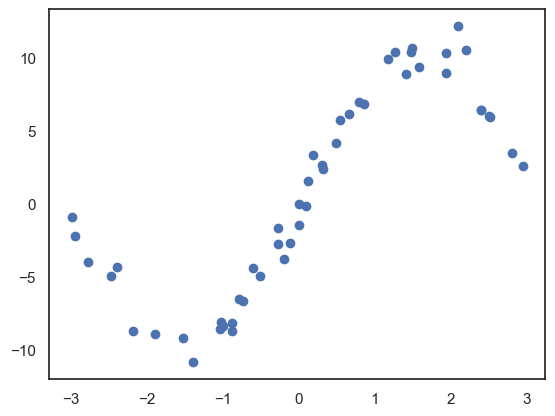

In [19]:
f, ax = plt.subplots()
ax.scatter(x, ground_truth)

To showcase the power of combining `tinygp` with a more expressive language, let's consider a switching model with two types of kernels. The first switch branch will include a prior over the parameters of the a `kernels.ExpSquared` kernel, and the second will provide a `kernels.Cosine` kernel. Following this path, we'll showcase how we can use `genjax.GaussianProcess` models inside of larger generative functions.

In [20]:
@genjax.gen
def model(data):
    trace("factor", genjax.TFPUniform)(0.1, 3.0)
    scale = trace("scale", genjax.TFPUniform)(0.1, 5.0)
    kernel_scaled = kernels.Cosine(scale=scale)
    gp = ggp.GaussianProcess(kernel_scaled)
    y = trace("y", gp)(data)
    return y

AttributeError: module 'genjax' has no attribute 'gen'

TypeError: 'ChoiceValue' object is not subscriptable

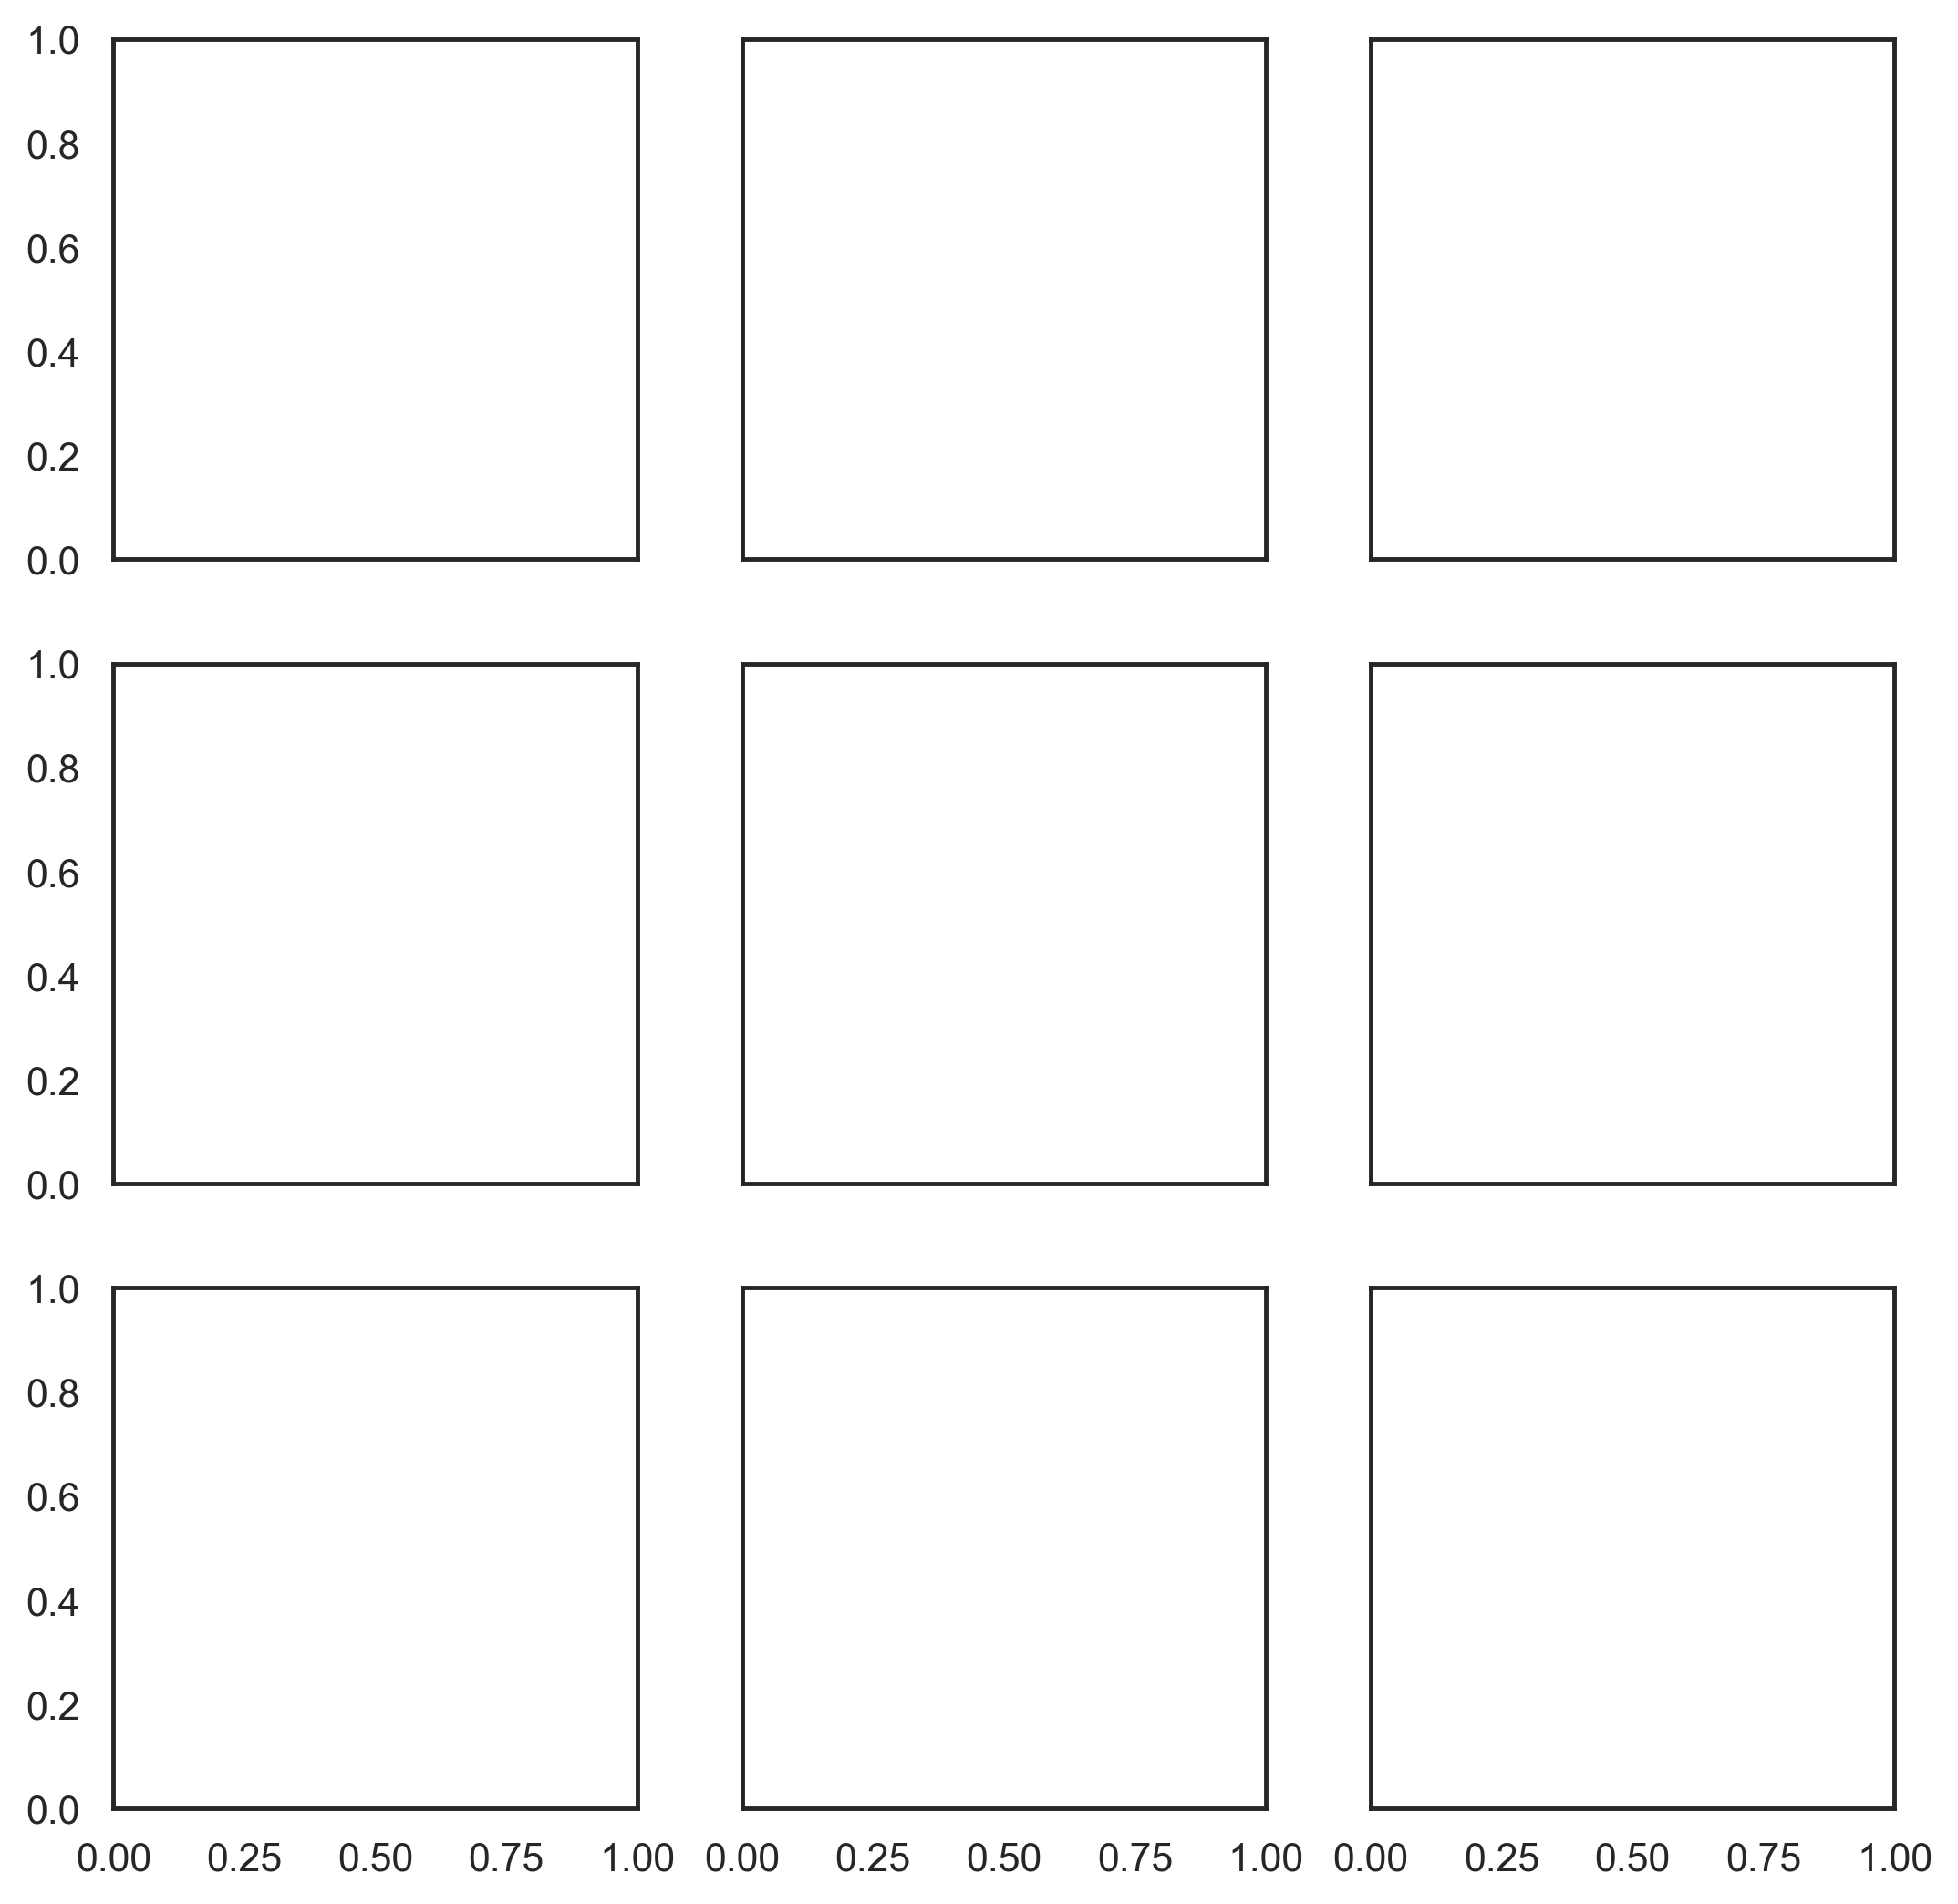

In [21]:
def viz(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)


f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True, dpi=280)
jitted = jax.jit(model.simulate)
for ax in axes.flatten():
    key, tr = jitted(key, (x,))
    y = tr.get_retval()
    viz(ax, x, y, marker=".")

plt.show()

We can easily use sampling importance resampling here, let's look at the results.

In [11]:
observations = genjax.choice_map({"y": ground_truth})
inf = genjax.sampling_importance_resampling(1000, model)
inf

SamplingImportanceResampling
├── num_particles
│   └── (const) 1000
├── model
│   └── BuiltinGenerativeFunction
│       └── source
│           └── <function model>
└── proposal
    └── (const) None

In [12]:
jitted = jax.jit(model.simulate)
key, tr = jitted(key, (x,))
tr.get_retval()

Array([-0.43208396, -0.58294547, -0.848159  , -0.7861588 , -0.545494  ,
       -0.16411299,  0.14950526,  0.2080805 ,  0.8111007 ,  0.86555636,
        0.8450676 ,  0.6299165 ,  0.32383266, -0.01688776, -0.30093664,
       -0.5840381 , -0.6380779 , -0.81765443, -0.7392957 , -0.6654223 ,
       -0.54848593, -0.21036375,  0.8061874 ,  0.82833725,  0.83593285,
       -0.02110198, -0.499939  , -0.5576827 , -0.81426835, -0.39774978,
        0.36000574,  0.62700665,  0.6447593 ,  0.83770037,  0.7923152 ,
        0.26099455, -0.24413885, -0.23712076, -0.38988945, -0.56829345,
       -0.5653826 , -0.84069645, -0.81233406, -0.6983161 , -0.59467906,
       -0.02127809,  0.23496075,  0.2594615 ,  0.36821437,  0.7813539 ],      dtype=float32)

In [24]:
jitted = jax.jit(jax.vmap(model.simulate, in_axes=(0, None)))
key, *sub_keys = jax.random.split(key, 100)
tr = jitted(sub_keys, (x,))

BeartypeCallHintParamViolation: Method genjax._src.generative_functions.distributions.distribution.Distribution.simulate() parameter key=[Traced<ShapedArray(uint32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(ui...] violates type hint typing.Union[jaxtyping.Key[Array, ''], jaxtyping.UInt32[Array, '2']] under non-default configuration BeartypeConf(claw_is_pep526=True, is_color=False, is_debug=False, is_pep484_tower=False, strategy=<BeartypeStrategy.O1: 2>, warning_cls_on_decorator_exception=None), as list [Traced<ShapedArray(uint32[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(ui...] not <protocol "jaxtyping.Key[Array, '']"> or <protocol "jaxtyping.UInt32[Array, '2']">.

In [ ]:
scale = tr["scale"]
factor = tr["factor"]
kernel_scaled = factor * kernels.ExpSquared(scale=scale)
gp = ggp.GaussianProcess(kernel_scaled)
v = gp.sample(key, x)
f, ax = plt.subplots()
ax.scatter(x, v)